In [541]:
import json
from os import listdir
import chess, chess.pgn, chess.engine
from chess.engine import Cp, Mate, MateGiven
from collections import Counter
from typing import Optional
from io import StringIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [542]:

class HelperClass:
    # returns all openings corresponding to the given list of files
    def getOpeningNames(self, username:str,files:list)->dict:
        #uses a map to get the opening names
        return list(map(lambda file : self.getGame(username,file)["opening"]["name"].split(":")[0],files))

    def getGame(self, username:str, file:str):
        return json.load(open("./games/{}/{}".format(username,file)))
    
    #returns a list of files where the username has the given color (if the color is not specified the function returns all user games)
    def getFiles(self, username:str,white:Optional[bool]=None):
        files = list()
        for file in listdir("./games/{}".format(username)):
            game = self.getGame(username=username,file=file)
            if white is not None:
                try:
                    if username==game["players"]["white" if white else "black"]["user"]["name"]:
                        files.append(file)
                except KeyError:
                    pass
            else:
                files.append(file)
        return files


In [543]:
class ChessAnalyser:
    def __init__(self) -> None:
        self.board = chess.Board()
        self.engine = chess.engine.SimpleEngine.popen_uci("./Stockfish/src/stockfish")
        
    def readJSONGameToPGN(self,JSONGame):
        pgn = StringIO(JSONGame["moves"])
        game = chess.pgn.read_game(pgn)
        return game 

    def loadGameToBoard(self, game:chess.pgn.Game):
        self.board = game.board()
        for move in game.mainline_moves():
            self.board.push(move)

    def getSelfEval(self, depth:Optional[int]=20):
        info = self.engine.analyse(self.board, chess.engine.Limit(depth=depth))
        return info["score"]
    
    def getEvalInfos(self, board:chess.Board, depth:Optional[int]=20):
        return self.engine.analyse(board, chess.engine.Limit(depth=depth))
    
    def loadGameEval(self, game:chess.pgn.Game,depth:Optional[int]=20):
        board = chess.Board()
        movesInfo = list()
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            movesInfo.append(self.getEvalInfos(board=board,depth=depth))
        
        return movesInfo
    
    #TODO consider player piece color
    def getFormattedInfos(self,game:chess.pgn.Game,depth:Optional[int]=20):
        infos = self.loadGameEval(game,depth)
        formattedInfos=[self.formatInfo(info) for info in infos]
        return formattedInfos

    def formatInfo(self,info):
            score = info["score"].white()
            mate_score = score.mate()
            centipawn_score =  score.score()/10 if score.score() is not None else None
            if "pv" in info:
                pv = self.formatMoves(info["pv"])
            else:
                pv = None
            return {
                "mate_score": mate_score,
                "centipawn_score": centipawn_score,
                "pv": self.formatMoves(pv)
            }           

    def formatMoves(self,pv):
        if pv is None:
            return ""
        return [move for move in pv]

        
        
    def plotEvalGraph(self,game:chess.pgn.Game,depth:Optional[int]=20):
        formattedInfos = self.getFormattedInfos(game,depth)
        evals = [(100 if 0 < info["mate_score"] else -100) if info["centipawn_score"] is None else info["centipawn_score"]  for info in formattedInfos]
        numberOfMoves=len(evals)
    
        x=np.arange(0,numberOfMoves,1)

        y1 = None
        y2 = None

        Y = evals
        print(evals)

        fig, ax = plt.subplots()
        
        #ax.fill_between(x,y1,y2, alpha=0.5)
        ax.plot(x,Y,color="red")
        
        #TODO count two moves as one turn!
        ax.set(xlim=(0, numberOfMoves),ylim=(-100, 100))
        plt.axhline(y=0)
        
        plt.show()

    
    def getBoard(self):
        return self.board
    
    def getEngine(self):
        return self.engine
    
    def playNewGame(self):
        self.board = chess.Board()
        i = 0
        while not self.board.is_game_over():
            print(self.board)
            if i % 2 == 0:
                print(self.getSelfEval(1))
            result = self.engine.play(self.board,chess.engine.Limit(depth=20))
            self.board.push(result.move)
            i += 1
            
        self.board
        
    def quitEngine(self):
        self.engine.quit()

[2.9, 3.6, 2.6, 1.9, -0.9, -0.9, -1.6, -1.7, -0.5, -1.1, -5.5, 1.2, 0.0, 0.2, -2.7, 1.0, -2.3, -2.7, -4.6, 0.9, 0.1, 12.5, 0.3, 7.3, 1.8, 13.0, 12.7, 12.2, 11.3, 19.4, 4.5, 6.5, -7.3, 1.5, -7.5, -5.5, -25.1, -7.9, -9.7, 36.4, 35.8, 44.6, 38.7, 67.4, 54.9, 63.9, -23.4, -35.4, -37.4, -39.3, -100, -100, -100, -100]


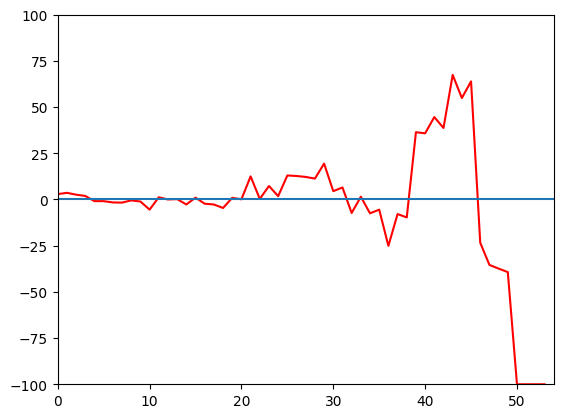

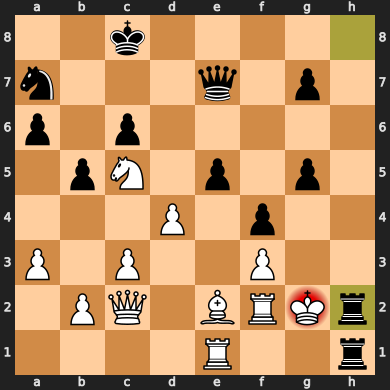

In [544]:
helperClass = HelperClass()
analyser = ChessAnalyser()

JSONgame = helperClass.getGame("Triumpfole",helperClass.getFiles("Triumpfole",True)[3])
game = analyser.readJSONGameToPGN(JSONgame)
analyser.loadGameToBoard(game)

#print(analyser.getSelfEval(2))
analyser.plotEvalGraph(game=game,depth=25)
analyser.getBoard()

# analyser.loadGameEval(game,10)


In [545]:
# if __name__ == "__main__":
#     helperClass = HelperClass()
#     #gets a saved game
#     game = helperClass.getGame("Triumpfole",helperClass.getFiles("Triumpfole",True)[0])
    
#     analyser = ChessAnalyser()
#     #updates the position on the board to the end position
#     analyser.readJSONGameToPGN(game)
    
#     #evaluates the end position
#     print(analyser.getEval(2))
    
#     analyser.playNewGame()
    
#     #quits the engine
#     analyser.quitEngine()